## This notebook contains only the final XGBoost model using the best hyperparameters identified during tuning. For details on other models, parameter search and threshold tuning, see fraaud_detection_full_workflow.ipynb

**In this final model notebook I have removed everything except for the final model and I have introduced a pipeline which contains the DictVectorizer and the model.**

# Goal Of This Project
**My goal is to detect at least 85% of fraud cases (recall>=0.85) while keeping precision above 40%. I am setting this goal because I am assuming a bussiness situation where missing a fraud case is more expensive than making a false alarm. Therefore I am prioritising recall in this project.**

In [1]:
import numpy as np 
import pandas as pd
df= pd.read_csv('/workspaces/Project_1_ML_Zoomcamp/Data/Synthetic_Financial_datasets_log.csv')
del df['isFlaggedFraud']
df.head()
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
41367,9,PAYMENT,14419.29,C2051925142,23860.97,9441.68,M1107228561,0.0,0.0,0.0
41368,9,PAYMENT,2023.43,C494253457,9441.68,7418.25,M1628425553,0.0,0.0,0.0
41369,9,PAYMENT,8872.04,C1953754290,7418.25,0.00,M1107808210,0.0,0.0,0.0
41370,9,PAYMENT,1415.98,C1928213310,0.00,0.00,M1830030711,0.0,0.0,0.0
41371,9,PAYMENT,7493.07,C10,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df.columns= df.columns.str.lower().str.replace(' ','_')
strings=['type','nameorig','namedest' ]
for i in strings:
    df[i]= df[i].str.lower().str.replace(' ','_')




In [3]:
# dropping identifiers columns
df= df.drop(columns=['nameorig','namedest'])
df.columns

Index(['step', 'type', 'amount', 'oldbalanceorg', 'newbalanceorig',
       'oldbalancedest', 'newbalancedest', 'isfraud'],
      dtype='object')

In [4]:
# Data Cleaning
df.duplicated().sum()
df.isnull().sum()
categorical=['type']
numerical=['step','amount','oldbalanceorg','newbalanceorig','oldbalancedest','newbalancedest']
df[numerical].corr()

,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest
step,1.000000,0.078031,-0.032364,-0.032747,-0.000336,0.015955
amount,0.078031,1.000000,0.017372,0.006254,0.291350,0.404677
oldbalanceorg,-0.032364,0.017372,1.000000,0.998363,0.128084,0.094292
newbalanceorig,-0.032747,0.006254,0.998363,1.000000,0.131019,0.094234
oldbalancedest,-0.000336,0.291350,0.128084,0.131019,1.000000,0.929220
newbalancedest,0.015955,0.404677,0.094292,0.094234,0.929220,1.000000


In [5]:
df['isfraud'].value_counts(normalize=True)

isfraud
0.0    0.997728
1.0    0.002272
Name: proportion, dtype: float64

In [6]:
# dropping missing values rows in the target
df= df.dropna(subset=['isfraud'])
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceorg     0
newbalanceorig    0
oldbalancedest    0
newbalancedest    0
isfraud           0
dtype: int64

In [7]:
# Applied log transform to mitigate outliers
outlier_col=['amount', 'oldbalanceorg', 'newbalanceorig', 'oldbalancedest', 'newbalancedest']


In [8]:
df.describe().round(2)


,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud
count,41371.00,41371.00,41371.00,41371.00,41371.00,41371.00,41371.00
mean,7.13,147860.82,788125.94,803065.80,849807.93,1164204.49,0.00
std,2.12,312334.17,2306155.73,2344428.50,2478389.84,2975844.40,0.05
min,1.00,1.77,0.00,0.00,0.00,0.00,0.00
25%,7.00,6976.44,0.00,0.00,0.00,0.00,0.00
50%,8.00,27190.50,19097.00,862.91,0.00,0.00,0.00
75%,8.00,178328.84,147116.00,155470.36,434973.25,803908.40,0.00
max,9.00,10000000.00,28547237.16,28617396.21,29584542.04,31306920.44,1.00


<Axes: xlabel='newbalanceorig', ylabel='Count'>

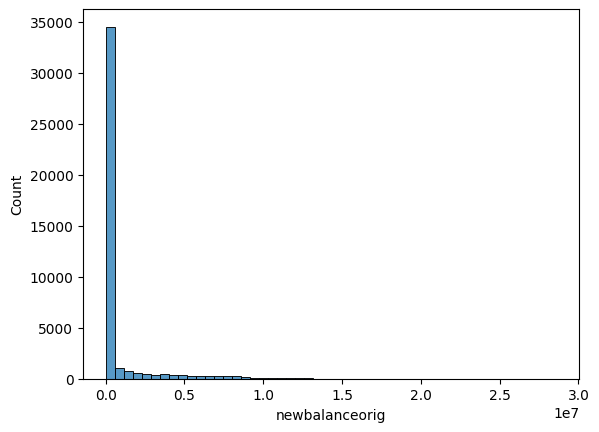

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.histplot(df['newbalanceorig'],bins=50)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41371 entries, 0 to 41370
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            41371 non-null  int64  
 1   type            41371 non-null  object 
 2   amount          41371 non-null  float64
 3   oldbalanceorg   41371 non-null  float64
 4   newbalanceorig  41371 non-null  float64
 5   oldbalancedest  41371 non-null  float64
 6   newbalancedest  41371 non-null  float64
 7   isfraud         41371 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.8+ MB


## Validation Framework

In [11]:
from sklearn.model_selection import train_test_split
df_fulltrain,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_train,df_val=train_test_split(df_fulltrain, test_size=0.25,random_state=42)


In [12]:
y_train=df_train['isfraud'].values
y_val= df_val['isfraud'].values
y_test=df_test['isfraud'].values

In [13]:
del df_train['isfraud']
del df_val['isfraud']
del df_test['isfraud']


## checking feature and mutual importance of the dataset  using the df_fulltrain

In [14]:
# checking risk ratio and feature difference
from IPython.display import display
fraud_rate=df_fulltrain['isfraud'].mean()
for i in categorical:
    print(i)
    df_group= df_fulltrain.groupby(i).isfraud.agg(['mean','count'])
    df_group['diff']= df_group['mean']-fraud_rate
    df_group['risk_ratio']= df_group['mean']/fraud_rate
    display(df_group)
    print()
    print()

type


,mean,count,diff,risk_ratio
type,,,,
cash_in,0.000000,6062,-0.002024,0.000000
cash_out,0.004204,8325,0.002180,2.076751
debit,0.000000,462,-0.002024,0.000000
payment,0.000000,15141,-0.002024,0.000000
transfer,0.010303,3106,0.008278,5.089197


In [15]:
# checking mutual information
from sklearn.metrics import mutual_info_score
def mutual_info_scores(series):
    return mutual_info_score(series,df_fulltrain['isfraud'])
mi= df_fulltrain[categorical].apply(mutual_info_scores)
mi
        

type    0.002351
dtype: float64

In [16]:
df_fulltrain[numerical].corrwith(df_fulltrain.isfraud)


step             -0.052596
amount            0.081374
oldbalanceorg    -0.000646
newbalanceorig   -0.014532
oldbalancedest   -0.010562
newbalancedest   -0.006515
dtype: float64

In [17]:

from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,precision_score,recall_score,precision_recall_curve,average_precision_score


import matplotlib.pyplot as plt





from sklearn.model_selection import KFold

kfold=KFold(n_splits=2,shuffle=True,random_state=42)

from sklearn.pipeline import make_pipeline


## Training an XGBoost classifier

In [18]:
from xgboost import XGBClassifier

## Retraining the final model on the fulltrain dataset

In [19]:
y_fulltrain=df_fulltrain.isfraud.values
del df_fulltrain['isfraud']

### Making a pipeline



In [20]:

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

passthrough_feature = ['step']

log_transformer= Pipeline(steps=[('log1p',FunctionTransformer(np.log1p,validate=False) )])
categorical_transformer=Pipeline(steps=[('onehotencode',OneHotEncoder(handle_unknown='ignore'))])
preprocessor=ColumnTransformer(transformers=[('log_transform',log_transformer,outlier_col),('categorical_transform',categorical_transformer,categorical),('passthrough_trans','passthrough',passthrough_feature)])
final_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('xgb_model',XGBClassifier(n_estimators=90,random_state=42,max_depth=5,min_child_weight=1,gamma=0,scale_pos_weight=10,colsample_bytree=0.7,eta=0.1))])


final_pipeline.fit(df_fulltrain,y_fulltrain)




,steps,"[('preprocessor', ...), ('xgb_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_transform', ...), ('categorical_transform', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Testing the final (XGBoost) model

In [21]:

y_score_test=final_pipeline.predict_proba(df_test)[:,1]
y_pred_test=y_score_test>=0.038
print('The average precision score of the final model:',average_precision_score(y_test,y_pred_test))
print('The recall score of the final model:',recall_score(y_test,y_pred_test))
print('The precision score of the final model:', precision_score(y_test,y_pred_test))
print('The roc_auc_score of the final model:',roc_auc_score(y_test,y_score_test))
print('The confusion matrix of the final model:',confusion_matrix(y_test,y_pred_test))


The average precision score of the final model: 0.4852110226128353
The recall score of the final model: 0.8888888888888888
The precision score of the final model: 0.5454545454545454
The roc_auc_score of the final model: 0.9982711858318066
The confusion matrix of the final model: [[8228   20]
 [   3   24]]


In [22]:
# Single transaction example. I will use this to test my model when I place it in a server
transaction = {
    'step': 1,
    'type': 'cash_in',
    'amount': 57809.81,
    'oldbalanceorg': 3434765.61,
    'newbalanceorig': 3492575.42,
    'oldbalancedest': 59666.0,
    'newbalancedest': 0.0
}

test_df_single=pd.DataFrame([transaction])
test_df_single

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest
0,1,cash_in,57809.81,3434765.61,3492575.42,59666.0,0.0


In [23]:
import joblib


In [24]:
joblib.dump(final_pipeline,'final_model_pipeline.pkl')
pipeline=joblib.load('final_model_pipeline.pkl')

# This is the information I will send as a request to test my model in the server
score=pipeline.predict_proba(test_df_single)[0,1]
if score >=0.038:
    print('This is a fraud transaction')
else:
    print('This is not a fraud transaction')

This is not a fraud transaction
